# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

# Configuration

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV


import graphviz
from sklearn.tree import export_graphviz

persons = pd.read_csv('./dataset/aug_train.csv')

## Métrica de Performance
Se van a utilizar como métricas 
* **Recall** : para identificar cuantas personas que estan dispuestas a cambiar de empleo encontramos.
Aun asi, para analizar los diferentes modelos tambien haremos uso de F1 y Acuraccy.

# Feature Engineering and DataFrameMapper

Aplicamos binnig en la feature "disciplina del candidato" agrupando los casos con menos aparicion en la categoria "Otros".
Para features binarias y categóricas de poca "variabilidad" tales como el "genero", "disciplina del candidato" y "tipo de compania" utilizamos OneHotEncoder. 


In [17]:
persons.count()

enrollee_id                19158
city                       19158
city_development_index     19158
gender                     14650
relevent_experience        19158
enrolled_university        18772
education_level            18698
major_discipline           16345
experience                 19093
company_size               13220
company_type               13018
last_new_job               18735
training_hours             19158
target                     19158
Relevent_experience_num    19158
Enrolled_university_num    18772
education_level_num        18698
major_discipline_num       16345
experience_num             19158
company_size_num           13220
last_new_job_num           19158
dtype: int64

In [3]:
persons = pd.read_csv('./dataset/aug_train.csv')
persons["Relevent_experience_num"] = persons.relevent_experience.replace(['Has relevent experience', 'No relevent experience'], [1, 0])
persons["Enrolled_university_num"] = persons.enrolled_university.replace(['no_enrollment', 'Full time course', 'Part time course',np.nan], [0, 1,0.5,np.nan]) 
persons["education_level_num"] = persons.education_level.replace(['Primary School', 'High School','Graduate', 'Masters', 'Phd',np.nan], [1,2,3,4,5,np.nan]) 
persons["major_discipline_num"] = persons.major_discipline.replace(['STEM', 'Business Degree', np.nan, 'Arts', 'Humanities', 'No Major','Other'], ['STEM','Other', np.nan,'Other','Other','No Major','Other'])
persons["experience_num"] = persons.experience.replace(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4','10', '14', '18', '19', '12', '3', '6', '9', '8', '20', np.nan], [21,  15, 5, 0, 11, 13, 7, 17, 2, 16, 1, 4, 10, 14, 18, 19, 12, 3, 6,9, 8, 20, 10])
persons["company_size_num"] = persons.company_size.replace([np.nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999'], [np.nan, 100, 10, 20000, 10000,5000,50,500,1000]) 
persons["last_new_job_num"] = persons.last_new_job.replace(['1', '>4', 'never', '4', '3', '2', np.nan], [1,5,-1,4,3,2,2])
mapper = DataFrameMapper([
    (['gender'], [OneHotEncoder()]),
    (['major_discipline_num'], [OneHotEncoder()]),
    (['company_type'], [OneHotEncoder()]),
    (['company_size_num'], [StandardScaler()]),
    (['last_new_job_num'], [StandardScaler()]),
    (['Enrolled_university_num'], None),
    (['education_level_num'], None),
    (['experience_num'], None),
    (['Relevent_experience_num'], None),
    (['training_hours'], None),
])
mapper.fit(persons)

# Test, train & validation sets
train, not_train = train_test_split(persons, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)


Decidimos utilizar el 60% del dataset para train (11494 registros) y el 40% restante para test y validation (3832 registros para cada uno).

# Entrenamiento

In [4]:
def evaluate_model(model, set_names=('train', 'validation', 'test'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.target
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['change', 'no change'])
            ax.yaxis.set_ticklabels(['change', 'no change'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

## Logistic Regression

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor score:  0.76292
Mejores parámetros: 
 {'max_iter': 400}


'Logistic Regression'

,Accuracy,Precision,Recall,F1
train,0.763442,0.561521,0.177448,0.269675
validation,0.760438,0.554839,0.180672,0.272583


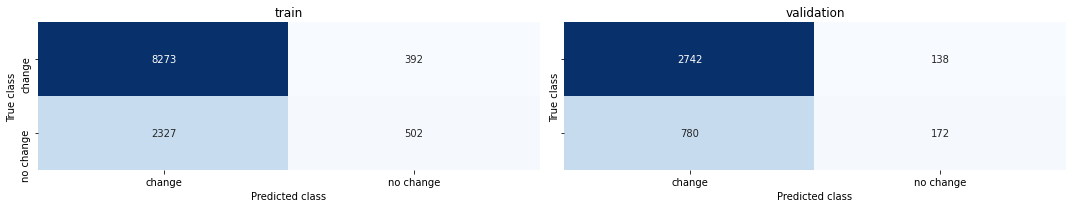

In [5]:
parameters = {'max_iter':[400, 800, 1200]}
clf = GridSearchCV(LogisticRegression(), parameters, refit=True, verbose=1)

lr_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

lr_model.fit(train, train.target)

print('Mejor score: ', round(clf.best_score_, 5))
print('Mejores parámetros: \n', clf.best_params_)
evaluate_model(lr_model, title='Logistic Regression', set_names=('train', 'validation'))

Analizando el mejor resultado obtenido, aplicando un maximo de 400 iteraciones, podemos observar como llegamos a obtener un 76% de accuracy en los sets de validation y train, esto quiere decir que acertamos la prediccion en un 76% de los casos. Adicionalmente, viendo la metrica de precision y recall, podemos ver que acertamos solo un 55% de las veces que indicamos que una persona estaba dispuesta a un cambio de empleo realmente era asi, y que solo pudimos encontrar un 18% de los casos positivos reales. Si vemos el desbalanceo que tenia el dataset (4 a 1) es entendible que cueste más predecir los casos positivos ya que estos son aquellos de los cuales menos entradas posee.

## KNN

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor score:  0.74848
Mejores parámetros: 
 {'n_neighbors': 20}


'KNN'

,Accuracy,Precision,Recall,F1
train,0.762746,0.610870,0.099328,0.170873
validation,0.749478,0.470588,0.067227,0.117647


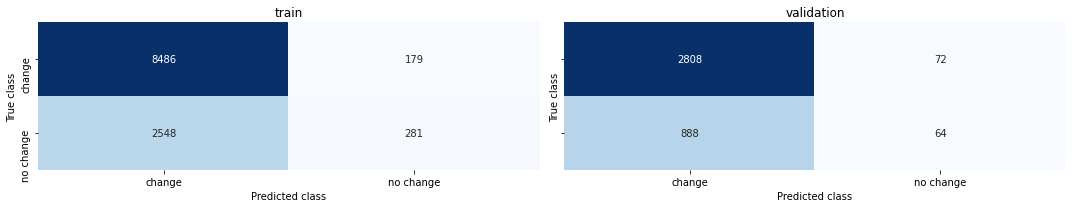

In [6]:
parameters = {'n_neighbors':[15, 20, 25]}
clf = GridSearchCV(KNeighborsClassifier(), parameters, refit=True, verbose=1)

knn_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

knn_model.fit(train, train.target)

print('Mejor score: ', round(clf.best_score_, 5))
print('Mejores parámetros: \n', clf.best_params_)
evaluate_model(knn_model, title='KNN', set_names=('train', 'validation'))

En este caso, la acuracy para cada uno de los sets dio un valor bastante similar, difiriendo en poco menos de un 2%. La metrica Recall es la más baja, se encontró solo un 6% de los positivos casos reales. Además, en la métrica de Precision vemos una gran diferencia entre los set de train y validation, indicando que porcentualmente acertamos menos cuando trabajamos con un set que no fue de entrenamiento, haciéndolo menos fiable que otras opciones.

## Decission Tree

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor score:  0.76379
Mejores parámetros: 
 {'max_depth': 5}


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.768662,0.574431,0.231884,0.330395
validation,0.757829,0.530303,0.220588,0.311573


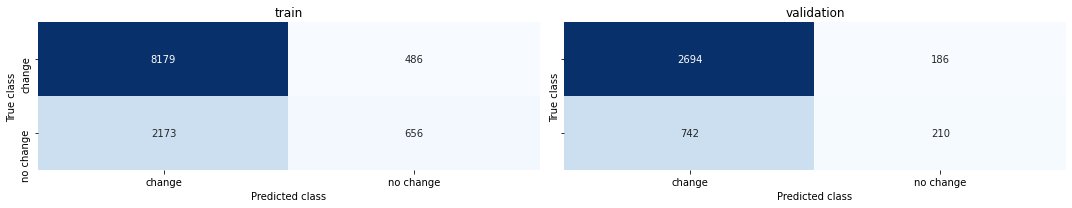

In [7]:
parameters = {'max_depth':[3, 5, 8]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, refit=True, verbose=1)

dt_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

dt_model.fit(train, train.target)

print('Mejor score: ', round(clf.best_score_, 5))
print('Mejores parámetros: \n', clf.best_params_)
evaluate_model(dt_model, title='Decision Tree', set_names=('train', 'validation'))

Este es el modelo más esperanzador de todos, donde podemos ver el mayor valor de F1 obtenido, separándolo en Precision y Recall se puede ver como Precision posee valores muy similares a lo obtenido en Regresion Logística, y donde principalmente destaca, es en la metrica de Recall indicando que en este caso encontramos aún más valores postivos que en los modelos previos.

Accuracy no posee diferencia respecto al resto de modelos.

In [8]:
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['change', 'no change'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

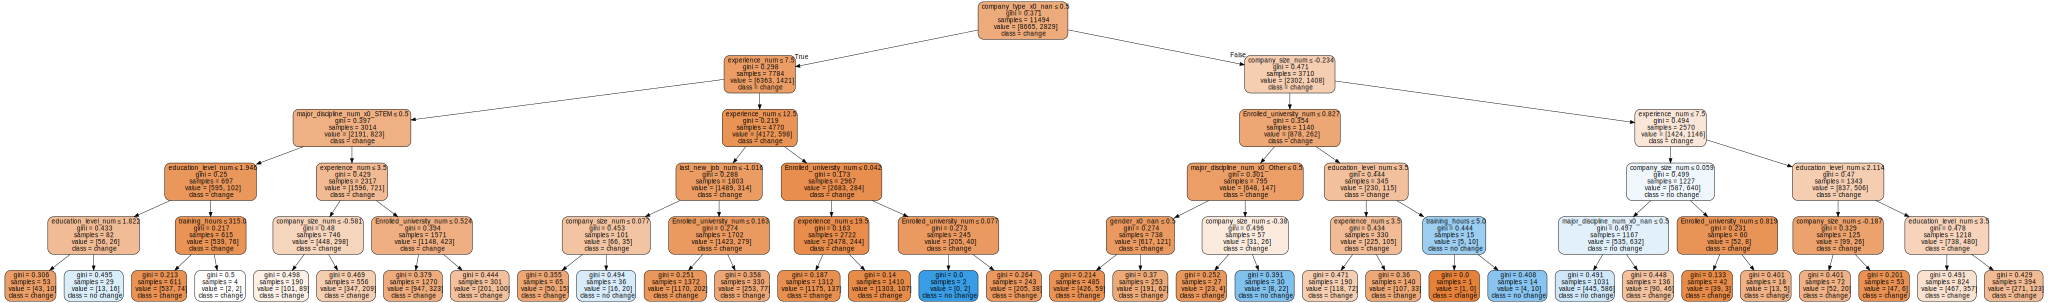

In [9]:
graph_tree(clf.best_estimator_, mapper.transformed_names_)

# Información para el cliente

A la hora de mostrarle al cliente se le mostrara el algoritmo aplicado sobre el dataset de test para asegurarse de que se evalue sobre un set de datos que no ha sido utilizado para entrenamiento. Se tendran en cuenta unicamente las métricas de Accuracy que serviran para indicar el porcentaje de aciertos y la metrica F1 como conjuncion de Precision y Recall, para mostrar la relación de aciertos en los valores positivos.

 Basandonos en los entrenamientos de cada modelo resulto ser el que tiene valores más prometedores en la métrica elegida (Recall), a pesar de que ninguno dio valores suficientemente confiables (>50%).

### LR

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.763442,0.561521,0.177448,0.269675
test,0.747651,0.544073,0.179719,0.270189


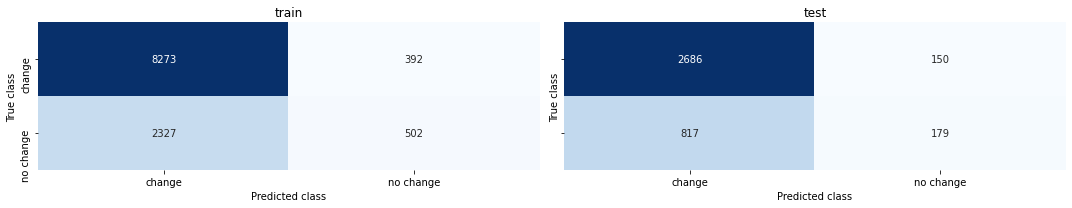

In [10]:
evaluate_model(lr_model, title='Decision Tree', set_names=('train','test'))

 * **F1 = 0.27**
 
 * **Accuracy = 0.74**
 
 * ### **Recall = 0.18**

### KNN

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.762746,0.610870,0.099328,0.170873
test,0.742432,0.529412,0.081325,0.140992


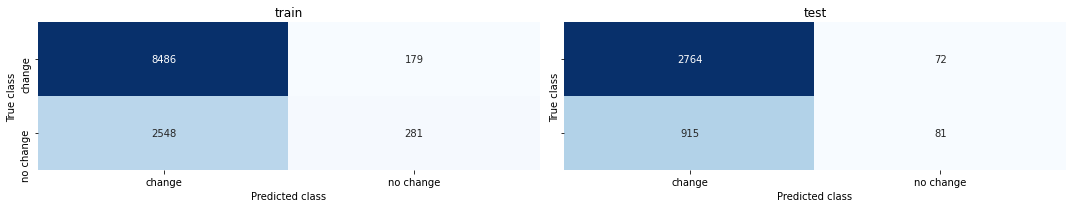

In [11]:
evaluate_model(knn_model, title='Decision Tree', set_names=('train','test'))

 * **F1 = 0.14**
 
 * **Accuracy = 0.74**
 
 * ### **Recall = 0.08** 

### Decision Tree

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.768662,0.574431,0.231884,0.330395
test,0.751827,0.561644,0.205823,0.301249


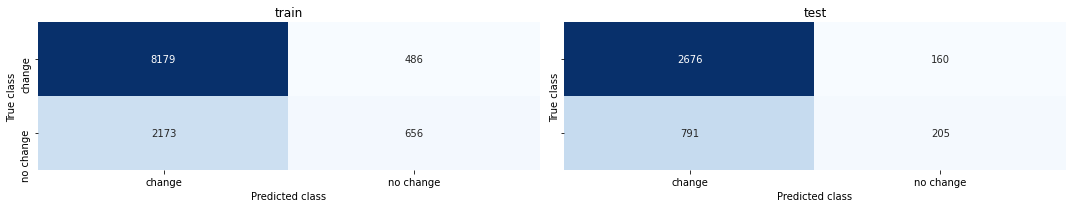

In [12]:
evaluate_model(dt_model, title='Decision Tree', set_names=('train','test'))

 * **F1 = 0.30**
 
 * **Accuracy = 0.75**
 
 * ### **Recall = 0.20** 